In [1]:
import shaqodoon_forecasting as sf

In [2]:
TRAIN_TEST_DATE_SPLIT = sf.settings.TRAIN_TEST_DATE_SPLIT
TEST_DATE_END = sf.settings.TEST_DATE_END

STATION_LAG_DAYS = sf.settings.STATION_LAG_DAYS
WEATHER_LAG_DAYS = sf.settings.WEATHER_LAG_DAYS

In [3]:
metadata_bulo_burti = sf.settings.STATION_METADATA["bulo_burti"]

dfs = sf.load.load_all_by_station_metadata(metadata_bulo_burti)

sf.preprocess.preprocess_2(
    dfs, station_lag_days=STATION_LAG_DAYS, weather_lag_days=WEATHER_LAG_DAYS
).to_csv("data/interim/bulo_burti_001-1.csv", index=False)

dfs = None


In [4]:
import pandas as pd

df = pd.read_csv("data/interim/bulo_burti_001-1.csv")
df.head()

,ds,level__m,lag1_level__m,lag3_level__m,lag7_level__m,lag14_level__m,belet_weyne_lag1_level__m,belet_weyne_lag3_level__m,belet_weyne_lag7_level__m,belet_weyne_lag14_level__m,...,ethiopia_shabelle_gode_lag7_precipitation_hours,ethiopia_shabelle_gode_lag14_precipitation_sum,ethiopia_shabelle_gode_lag14_precipitation_hours,ethiopia_shabelle_gode_forecast1_precipitation_sum,ethiopia_shabelle_gode_forecast1_precipitation_hours,ethiopia_shabelle_gode_forecast3_precipitation_sum,ethiopia_shabelle_gode_forecast3_precipitation_hours,ethiopia_shabelle_gode_forecast7_precipitation_sum,ethiopia_shabelle_gode_forecast7_precipitation_hours,y
0,2021-11-24,2.48,2.51,2.60,2.78,3.42,3.30,3.45,3.85,4.45,...,3.0,0.0,0.0,0.000000,0.0,0.4,3.0,0.0,0.0,-0.03
1,2021-11-25,2.45,2.48,2.55,2.74,3.30,3.24,3.38,3.66,4.38,...,0.0,0.0,0.0,19.900002,7.0,0.1,1.0,0.0,0.0,-0.03
2,2021-11-26,2.40,2.45,2.51,2.69,3.22,3.20,3.30,3.66,4.38,...,0.0,0.0,0.0,0.400000,3.0,0.0,0.0,0.0,0.0,-0.05
3,2021-11-27,2.36,2.40,2.48,2.66,3.11,3.10,3.24,3.55,4.27,...,0.0,0.8,2.0,0.100000,1.0,0.0,0.0,0.0,0.0,-0.04
4,2021-11-28,2.30,2.36,2.45,2.60,3.02,3.10,3.20,3.45,4.18,...,0.0,0.1,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,-0.06


In [5]:
train_df, test_df = (
    df[(df["ds"] < TRAIN_TEST_DATE_SPLIT)],
    df[(df["ds"] >= TRAIN_TEST_DATE_SPLIT)]
)

# add buffer for lag
test_df = test_df.iloc[max([max(STATION_LAG_DAYS), max(WEATHER_LAG_DAYS)]):, :]

# zoom on time frame
if TEST_DATE_END:
    test_df = test_df[test_df["ds"] <= TEST_DATE_END]

{
    "train_df": (train_df["ds"].min(), train_df["ds"].max()), 
    "test_df": (test_df["ds"].min(), test_df["ds"].max())
}

{'train_df': ('2021-11-24', '2023-09-30'),
 'test_df': ('2023-10-15', '2024-11-18')}

c:\Users\tspetebroot\git\esg-hackathon-shaqodoon\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
23:37:16 - cmdstanpy - INFO - Chain [1] start processing
23:37:16 - cmdstanpy - INFO - Chain [1] done processing


drop NA rows effect: 391/400 (97.75%)


C:\Users\tspetebroot\AppData\Local\Temp\ipykernel_38032\4263367175.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


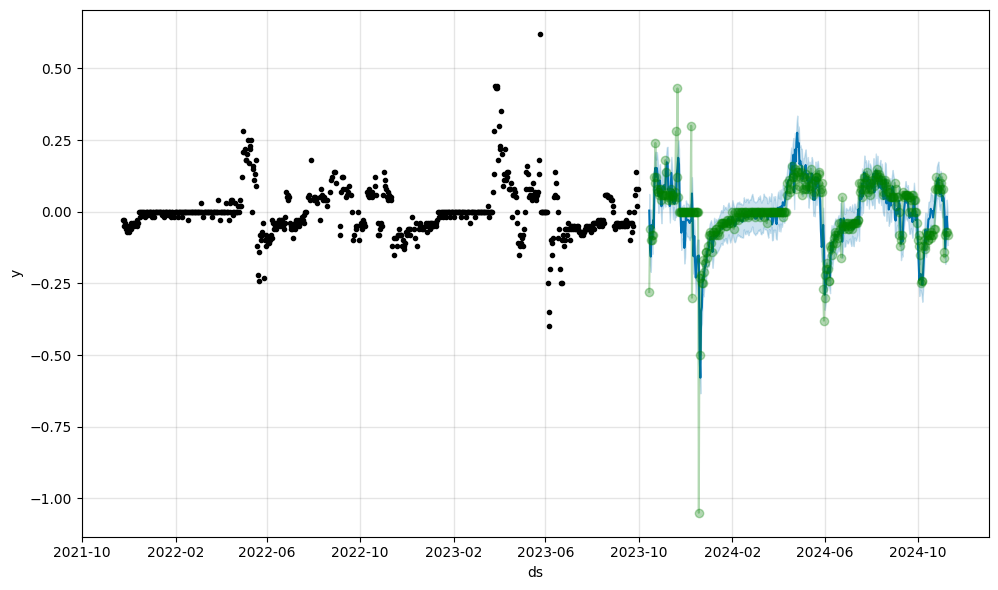

In [6]:
from prophet import Prophet

# Initialize the Prophet model
m = Prophet(weekly_seasonality=False, growth='flat')

# Add the regressors to the model
for r in [c for c in df.columns if c not in ["y", "ds", "level__m"]]:
    m.add_regressor(r)

# Fit the model
m.fit(train_df)

# FIXME: QUICKFIX to avoid error
count_test_df_raw = len(test_df.index)
test_df = test_df.dropna()
count_test_df_no_na = len(test_df.index)
print(f"drop NA rows effect: {count_test_df_no_na}/{count_test_df_raw} ({count_test_df_no_na/count_test_df_raw:.2%})")

test_df['ds'] = pd.to_datetime(test_df['ds'])

# Make predictions
forecast = m.predict(test_df)

# Plot the forecast
fig = m.plot(forecast)
ax = fig.gca()
ax.plot(test_df['ds'], test_df['y'], label='Test data', color='green', alpha=0.3, marker='o')

fig.show()

Text(0, 0.5, 'river level (m)')

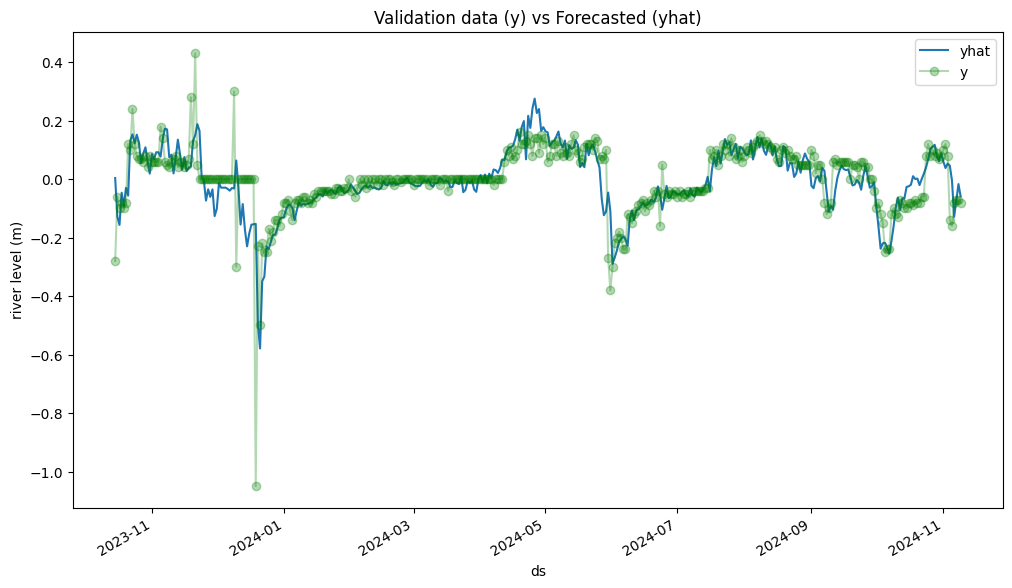

In [7]:
import matplotlib.pyplot as plt

df = forecast.loc[:, ["ds", "yhat"]].merge(test_df.loc[: ,["ds", "y"]], on='ds')

fig, ax = plt.subplots(1, 1, figsize=(12,7))
ax.set_title("Validation data (y) vs Forecasted (yhat)")
df.plot(x="ds", y="yhat", ax=ax)
df.plot(x="ds", y="y", ax=ax, color='green', alpha=0.3, marker='o')
ax.set_ylabel("river level (m)")

In [8]:
from prophet.utilities import regressor_coefficients

regressor_coef = regressor_coefficients(m)
regressor_coef[['regressor', 'regressor_mode', 'coef']].sort_values('coef')

,regressor,regressor_mode,coef
1,lag3_level__m,additive,-0.361665
5,belet_weyne_lag3_level__m,additive,-0.045118
7,belet_weyne_lag14_level__m,additive,-0.010363
64,ethiopia_shabelle_gode_lag14_precipitation_sum,additive,-0.002583
60,ethiopia_shabelle_gode_lag3_precipitation_sum,additive,-0.002179
...,...,...,...
61,ethiopia_shabelle_gode_lag3_precipitation_hours,additive,0.003593
3,lag14_level__m,additive,0.005787
2,lag7_level__m,additive,0.010567
4,belet_weyne_lag1_level__m,additive,0.076651


In [9]:
f"RMSE: {((df.y - df.yhat) ** 2).mean() ** .5:.4} meters"

'RMSE: 0.08229 meters'